# Food demand forcasting using Time Series Model

## Story: 


In the begining of this course, I want to learn some ML model that can help me predict some event in the future. So that I choose this project for my final project.
It is about use time series model to forcast food demand of a food material supplier. They have collected data in weeks. And I will use time series to forcast 1 type of food in the future ( next 10 weeks)


## Data analysic

In [7]:
#load all neccessary libs
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [8]:
#read  training data set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
meal_info = pd.read_csv('meal_info.csv')
fullfill_info = pd.read_csv('fulfilment_center_info.csv')

In [9]:
#head of these table
train.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [10]:
meal_info.head(5)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


after check some data in this data set , I found that it has a lot of difference meal_id. But my ID is that i only want to predict some "type of food" . So that in first step i will change all meal_id and group it to the same category .

In [11]:
meal_info['category'].unique()


array(['Beverages', 'Extras', 'Soup', 'Other Snacks', 'Salad',
       'Rice Bowl', 'Starters', 'Sandwich', 'Pasta', 'Desert', 'Biryani',
       'Pizza', 'Fish', 'Seafood'], dtype=object)

There is 14 types of food but i will get sameple for 1 kind of food. In this file is "Beverage".

In [12]:
fullfill_info.head(5)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [14]:
# merge 2 data train and meal Info
new_train =  train.join(meal_info
             .set_index("meal_id")
             .loc[:, ["category"]],
             on="meal_id")
# new_test =  test.join(meal_info
#              .set_index("meal_id")
#              .loc[:, ["category"]],
#              on="meal_id")

In [15]:
#I check my new train data set to see that different meal id will have same beverages here.
new_train.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages


In [16]:
#new_test.head(5)

In [17]:
# now we will group by same week and category for future analysic
new_train = new_train.groupby(["week","category"]).sum()
#y.to_frame().set_index('category')
new_train = new_train.reset_index()

# create my own data train
train_beverages = new_train.loc[new_train["category"]=="Beverages"]
train_beverages.set_index("week")
train_beverages = train_beverages[["week","num_orders"]]
train_beverages.head()

,week,num_orders
0,1,322382
12,2,381602
24,3,332159
36,4,345707
48,5,280863


In [19]:
y_beverages = train_beverages

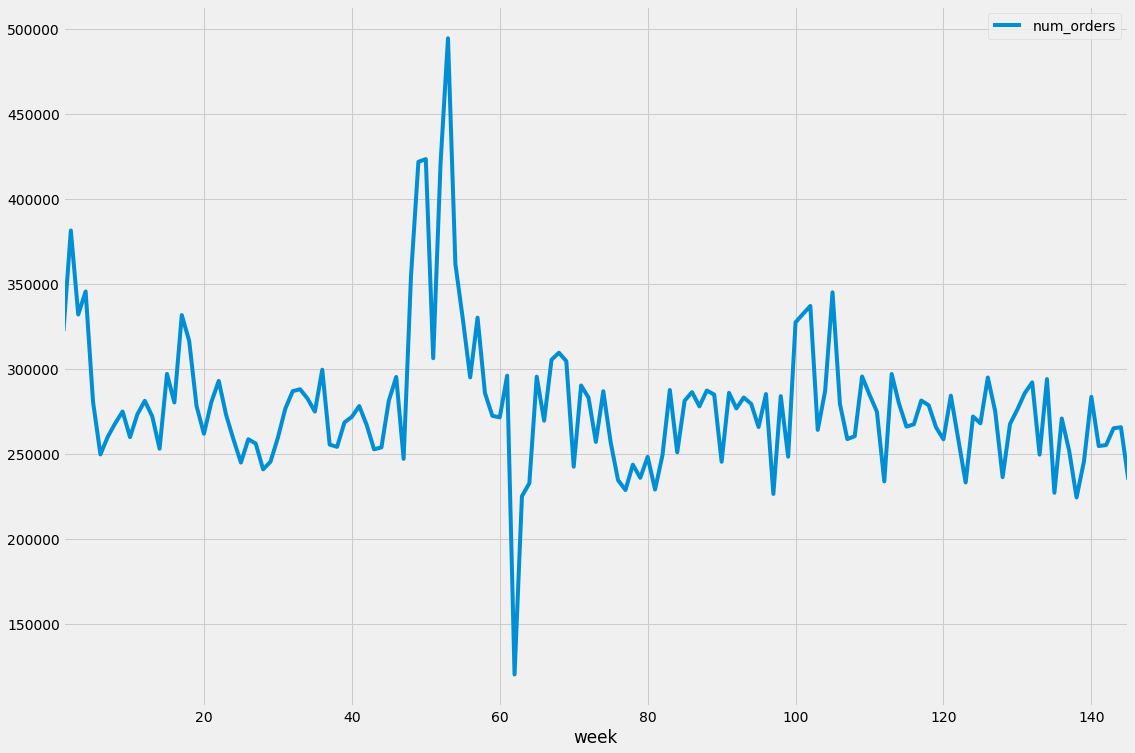

In [20]:
y_beverages.plot(x="week", y="num_orders",figsize=(17,12))  

Now i meet 2 problem about my data set.
1./ My data have week is a number not a time series, that will make my model can not work in the future.
2./ I see very high num order in 1 week and another very low num order. That might me make this data  become stationary.

So that i solve them as below

In [22]:
# i create a new function that tranform my week become the week of a year. and i asume that this company is start on 2016.
# so that week 1 will be 201601 ,... week 53 will be 201701,....
def transformWeektoTS(startyear,week):
    output = (startyear + week//52) * 100 + (week % 52)
    return (str(output) + '-0')

y_beverages["week"] = y_beverages["week"].apply(lambda x: transformWeektoTS(2016,x))
y_beverages["week"] = pd.to_datetime(y_beverages["week"],format = "%Y%W-%w")




In [24]:
y_beverages = y_beverages.reset_index()
y_beverages = y_beverages.set_index("week")
y_beverages.head() # look at this data again

,index,num_orders
week,,
2016-01-10,0,322382
2016-01-17,12,381602
2016-01-24,24,332159
2016-01-31,36,345707
2016-02-07,48,280863


now my week become the time series data and it will be continously weekly. I can use it as index in time series model.

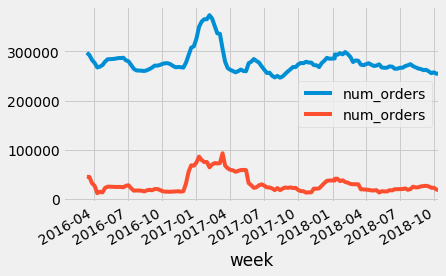

In [25]:
# Using pd.series.rolling to calculate mean and std for item_cnt_day series with window=12
# plot mean and std values
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html

ax = y_beverages.rolling(window=10).mean().plot(y="num_orders")
y_beverages.rolling(window=10).std().plot(y="num_orders", ax=ax)

now I use rolling to check the means of this number count. i show that I have a rage of week that have very high demand. but it only happens 1 times on our data. So that I think it is the residual of this data set.

I have a quick look in my data in these straight weeks and found that it is very high demand because the promotion and very low because the price of this week is very high. Our project does not say anything about this data so that i cant find future information for this week.


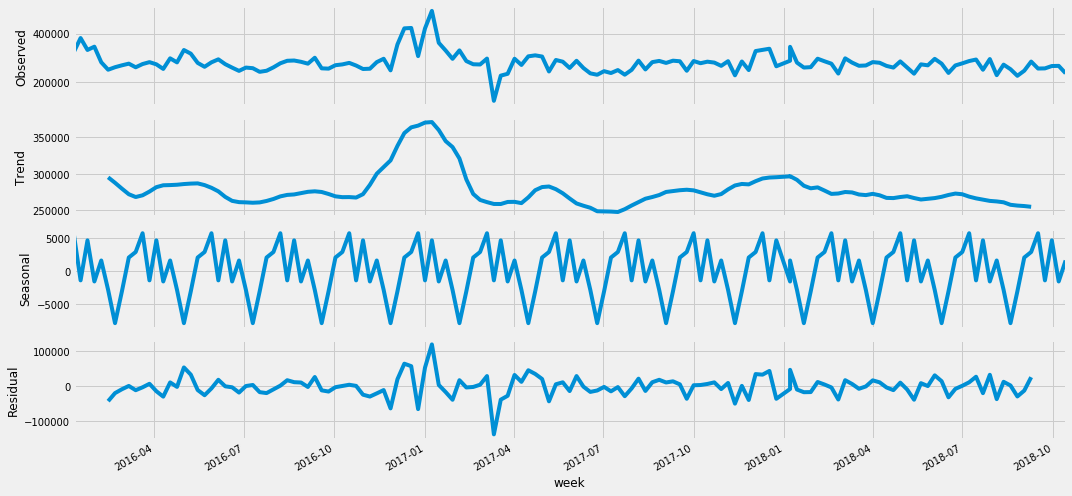

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams.update({'figure.figsize': (15,7), 'font.size': 10})
# Plot decompose diagram using seasonal_decompose
decomposition = seasonal_decompose(y_beverages["num_orders"],freq=10, model="additive")
fig = decomposition.plot();

After I decompose. I show that this data dont have TREND ( because it almost strainght line(except residual). And our Data have SEASONAL very clear.

## Train model

In [27]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [29]:
# Let's test with original timeseries
test_stationarity(y_beverages["num_orders"])

Results of Dickey-Fuller Test:
Test Statistic                  -4.196896
p-value                          0.000667
#Lags Used                       5.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64


And now once again i test for stationary for my data train set. and got a very good score p-value only 0.000667 so that this data is STATIONARY

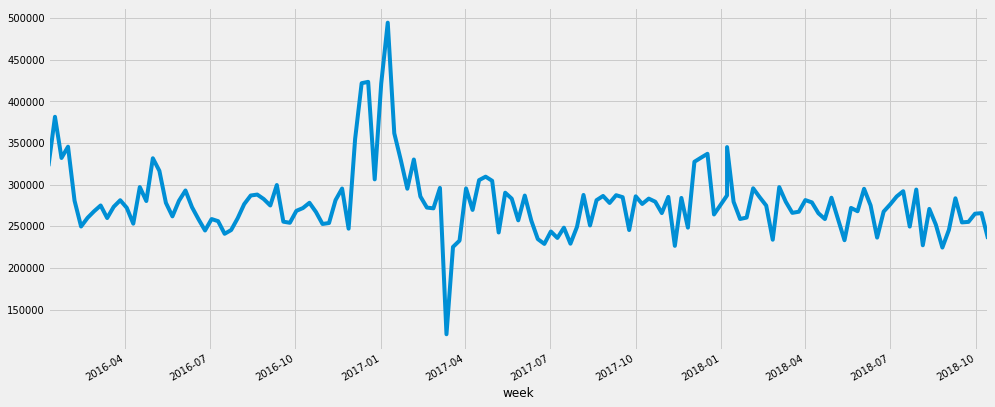

In [30]:
ts = y_beverages['num_orders']
ts.plot(y = "num_orders")

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


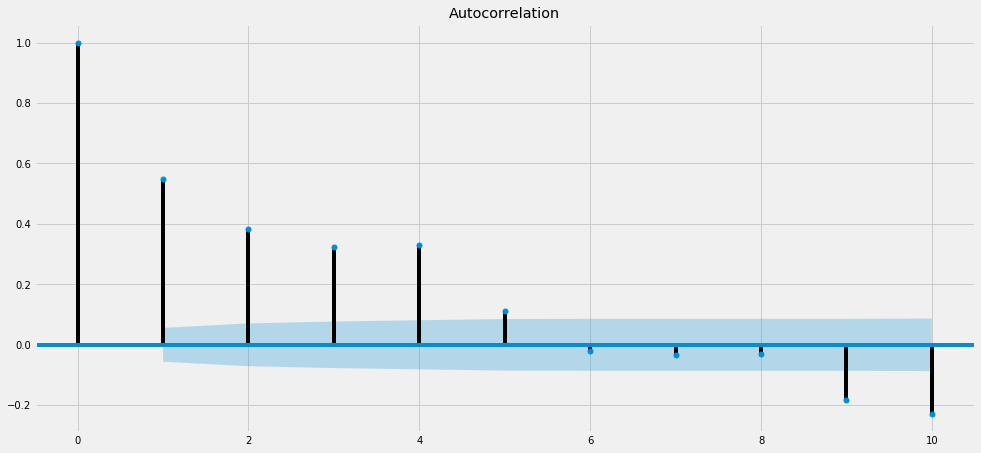

In [37]:
plot_acf(ts, lags=10, alpha=0.5);

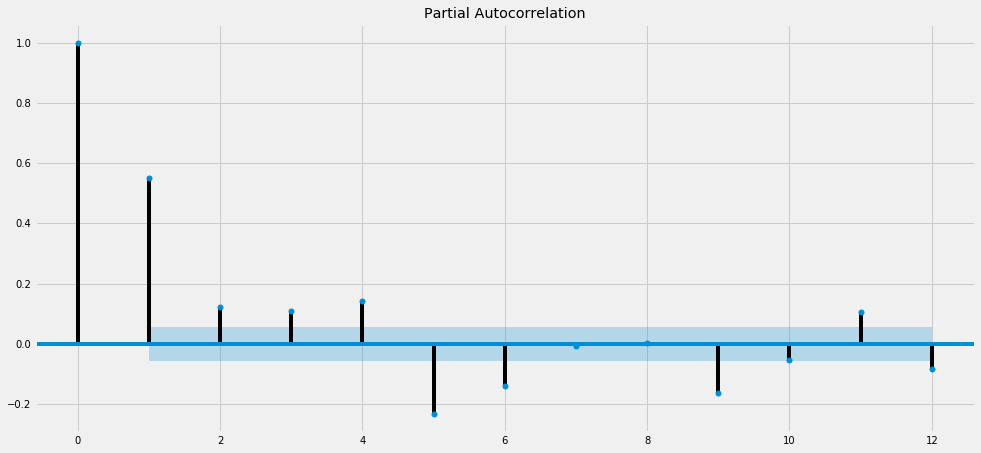

In [38]:
# Plot Partial Autocorrelation of ts with lags=12, alpha=0.5
# Your code here
plot_pacf(ts,lags=12, alpha=0.5);

I use these function to find out which parameters are the best for ARMA model and crealy it is ( 1,1)

In [39]:
from statsmodels.tsa.arima_model import ARMA

best_aic = np.inf
best_order = None
best_model = None

rng = range(5)
for i in rng:
    for j in rng:
        if i == j == 0:
            continue
        try:
            # Create and train ARMA model with order=(i, j)
            model = ARMA(order=(i,j)).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (i, j)
                best_model = model
        except: continue
print('AIC: {:6.5} | order: {}'.format(best_aic, best_order))

AIC:    inf | order: None


In [52]:
model =  ARMA(ts,order=(1,1)).fit()
predict = model.predict(start=0,end=144)

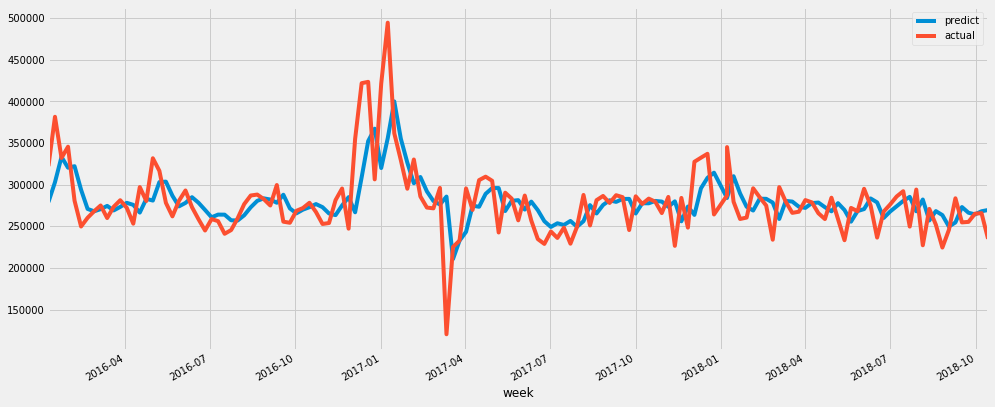

In [53]:
# Let's plot actual and predict values
# Your code here
predict.plot(label="predict")
ts.plot(label="actual")
plt.legend();

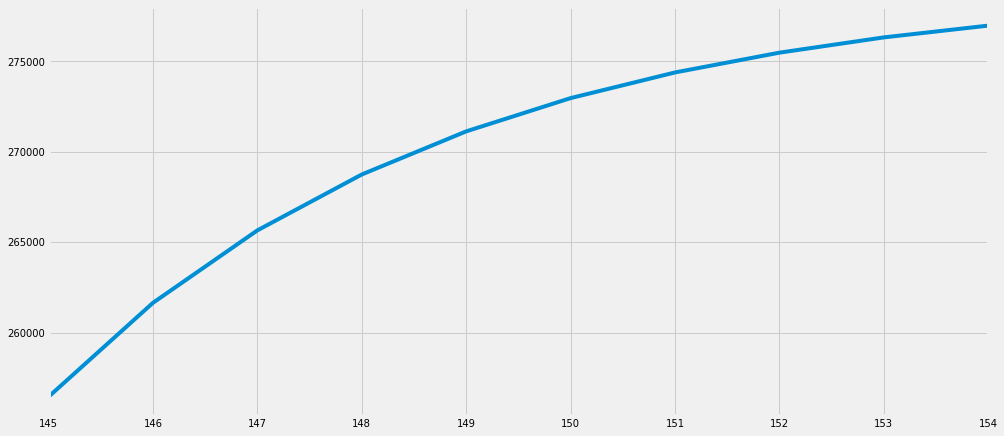

In [54]:
predict2 = model.predict(start=145,end=154)
predict2.plot(label="predict")

## MSE score

In [55]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(ts, predict)

0.015660224523224686

## Future research

My project only train for 1 type of food. but it can train for all other food type and make a complete suggestion for supllier.
I think the final question of my project is : can we focast all the food for each center_id so that the supplier can arange their material better.may be the random forest can solve this question better than time series.

# Thanks